**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## Using SGD on MNIST

## Background

### ... about machine learning (a reminder from lesson 1)

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies).  We looked at random forests in depth as we analyzed the Blue Book for Bulldozers dataset.

2. Multi-layered neural networks learnt with SGD (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this lesson, we will start on the 2nd approach (a neural network with SGD) by analyzing the MNIST dataset.  You may be surprised to learn that **logistic regression is actually an example of a simple neural net**!

### About The Data

In this lesson, we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


## Imports and data

We will be using the fastai library, which is still in pre-alpha.  If you are accessing this course notebook, you probably already have it downloaded, as it is in the same Github repo as the course materials.

We use [symbolic links](https://kb.iu.edu/d/abbe) (often called *symlinks*) to make it possible to import these from your current directory.  For instance, I ran:

    ln -s ../../fastai
    
in the terminal, within the directory I'm working in, `home/fastai/courses/ml1`.

In [287]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
from fastai.imports import *
# from fastai.torch_imports import *
# from fastai.io import *

In [289]:
path = 'data/mnist/'

Let's download, unzip, and format the data.

In [290]:
import os
os.makedirs(path, exist_ok=True)

In [291]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [292]:
from fastai.io import *

In [293]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [294]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [295]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [296]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [297]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [298]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [299]:
x_valid.shape

(10000, 784)

In [300]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

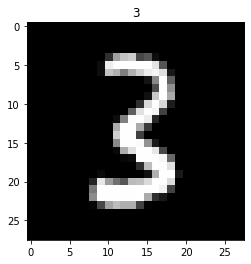

In [301]:
show(x_imgs[0], y_valid[0])

In [302]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [303]:
y_valid[0]

3

We can look at part of an image:

In [304]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

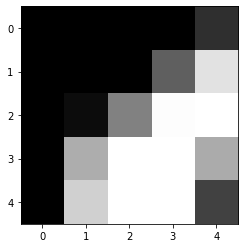

In [305]:
show(x_imgs[0,10:15,10:15])

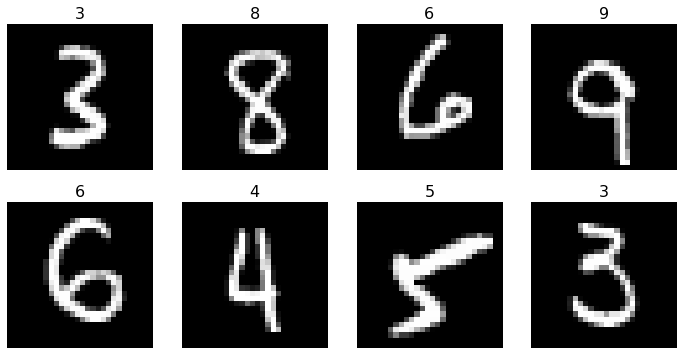

In [306]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks

We will take a deep look *logistic regression* and how we can program it ourselves. We are going to treat it as a specific example of a shallow neural net.

**What is a neural network?**

A *neural network* is an *infinitely flexible function*, consisting of *layers*.  A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*).

One of the tricky parts of neural networks is just keeping track of all the vocabulary! 

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif from fast.ai's deep learning course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

### PyTorch

We will be using the open source [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.  This is the highest level, simplest way to get started with deep learning. Please note that fastai requires Python 3 to function. It is currently in pre-alpha, so items may move around and more documentation will be added in the future.

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

### About GPUs

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.
- **Use crestle, through your browser**: [Crestle](https://www.crestle.com/) is a service that gives you an already set up cloud service with all the popular scientific and deep learning frameworks already pre-installed and configured to run on a GPU in the cloud. It is easily accessed through your browser. New users get 10 hours and 1 GB of storage for free. After this, GPU usage is 34 cents per hour. I recommend this option to those who are new to AWS or new to using the console.
- **Set up an AWS instance through your console**: You can create an AWS instance with a GPU by following the steps in this  [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]  AWS charges 90 cents per hour for this.

## Neural Net for Logistic Regression in PyTorch

In [307]:
import cv2

In [308]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [310]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)# .cuda()

In [311]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)# .cuda()

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

In [312]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [313]:
loss=nn.NLLLoss()
metrics=[accuracy]
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

### Loss functions and metrics

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [314]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [315]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss is should be much larger.

`loss = -log(1-0.9) = 2.30`

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

For multi-class classification, we use *negative log liklihood* (also known as *categorical cross entropy*) which is exactly the same thing, but summed up over all classes.

### Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [316]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      1.129628   0.997588   0.8761    
    1      1.242171   1.072882   0.8828                      
    2      1.22719    0.966619   0.8792                      
    3      1.278039   1.394284   0.8469                      
    4      1.182752   0.978266   0.8661                      



[0.9782658745288849, 0.8661]

In [317]:
set_lrs(opt, 1e-2)

In [318]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.444654   0.452055   0.9202    
    1      0.327865   0.362047   0.9242                       
    2      0.336313   0.327922   0.9198                       



[0.3279215093135834, 0.9198]

In [319]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.280475   0.314054   0.9199    
    1      0.271374   0.309016   0.9176                       
    2      0.269991   0.295908   0.9188                       
    3      0.27079    0.289263   0.9233                       
    4      0.270791   0.291094   0.9195                       



[0.29109437121152876, 0.9195]

In [320]:
set_lrs(opt, 1e-2)

In [321]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.278403   0.281025   0.924     
    1      0.267278   0.291257   0.921                        
    2      0.267529   0.283956   0.9206                       



[0.28395567965507507, 0.9206]

In [322]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([7840, 10], 7850)

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [323]:
preds = predict(net, md.val_dl)

In [324]:
preds.shape

(10000, 10)

**Question**: Why does our output have length 10 (for each image)?

In [325]:
preds.shape

(10000, 10)

In [326]:
import pandas as pd
pd.DataFrame(preds[:5,]).T

,0,1,2,3,4
0,-10.364497,-14.838695,-4.041882,-14.078316,-10.558451
1,-4.205998,-11.898415,-13.572091,-12.999176,-13.199899
2,-2.145971,-5.492990,-3.164496,-8.956459,-3.375121
3,-0.276352,-5.943861,-6.896782,-9.361632,-10.905622
4,-11.135065,-7.543856,-5.057311,-5.441741,-12.704797
5,-4.094454,-5.423422,-3.479576,-12.192903,-7.446001
6,-6.323208,-14.490229,-0.103751,-14.225380,-0.043044
7,-16.865433,-13.165251,-8.865495,-4.400570,-23.512514
8,-2.395973,-0.011991,-7.869158,-10.385041,-4.922134
9,-12.208735,-8.371435,-10.362870,-0.017000,-17.969942


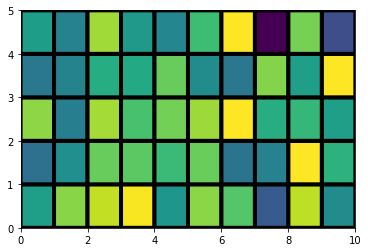

In [327]:
plt.pcolor(preds[:5,], edgecolor='k', linewidths=4)

In [328]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [329]:
preds = preds.argmax(1)

Let's check how accurate this approach is on our validation set. You may want to compare this against other implementations of logistic regression, such as the one in sklearn. In our testing, this simple pytorch version is faster and more accurate for this problem!

In [330]:
np.mean(preds == y_valid)

0.9206

Let's see how some of our predictions look!

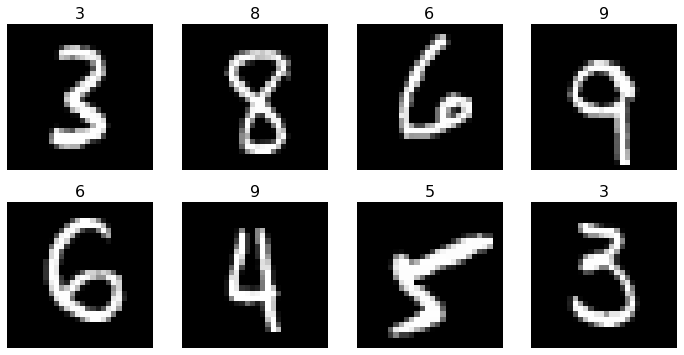

In [134]:
plots(x_imgs[:8], titles=preds[:8])

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [151]:
torch.randn(3,4)

tensor([[ 1.0134,  1.1989,  0.3598,  0.3154],
        [ 0.0392, -0.8406, -1.3703, -1.2463],
        [ 0.2756, -0.0430, -0.6427,  0.9695]])

In [152]:
torch.randn(3,4)/3

tensor([[ 0.3122,  0.0717,  0.3768,  0.4280],
        [-0.7638,  0.4477, -0.0551, -0.9194],
        [ 0.5135, -0.0284, -0.0518,  0.0588]])

In [153]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [155]:
net2 = LogReg()# .cuda()
opt=optim.Adam(net2.parameters())

In [156]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.309962   0.590206   0.9106    



[0.5902055502064526, 0.9106]

In [157]:
dl = iter(md.trn_dl)

In [158]:
xmb,ymb = next(dl)

In [166]:
xmb.shape, xmb

(torch.Size([64, 784]),
 tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]))

In [167]:
vxmb = Variable(xmb) # .cuda())
vxmb.shape, vxmb

(torch.Size([64, 784]),
 tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]))

In [172]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[1.7720e-03, 1.5441e-06, 1.6486e-05, 6.6895e-03, 2.9831e-06, 9.7028e-01,
         4.7559e-08, 5.1032e-03, 1.5662e-02, 4.7384e-04],
        [3.1329e-03, 5.7782e-08, 6.5651e-09, 1.3934e-03, 6.8517e-05, 9.7945e-01,
         7.9831e-08, 5.2396e-04, 1.3843e-02, 1.5858e-03],
        [3.8226e-08, 3.6718e-11, 1.1874e-06, 3.2942e-05, 8.2172e-09, 3.4324e-08,
         2.1130e-10, 9.9991e-01, 9.0998e-07, 5.3909e-05]],
       grad_fn=<SliceBackward>)

In [177]:
preds = preds.data.max(1)[1]; preds

tensor([5, 5, 7, 0, 6, 4, 2, 6, 2, 8, 0, 1, 4, 9, 2, 7, 6, 1, 9, 8, 4, 7, 8, 4,
        0, 2, 1, 6, 9, 4, 2, 1, 7, 6, 6, 4, 5, 2, 5, 0, 0, 0, 5, 2, 8, 1, 8, 3,
        2, 6, 4, 1, 9, 0, 7, 0, 3, 8, 7, 3, 1, 3, 2, 0])

Let's look at our predictions on the first eight images:

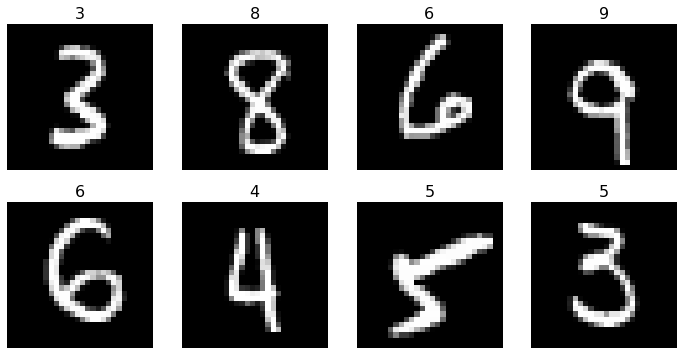

In [178]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [179]:
np.mean(preds == y_valid)

0.9106

## Aside about Broadcasting and Matrix Multiplication

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [180]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])
a,b

(array([10,  6, -4]), array([2, 8, 7]))

In [181]:
a + b

array([12, 14,  3])

In [182]:
(a < b).mean()

0.6666666666666666

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [183]:
a

array([10,  6, -4])

In [184]:
a > 0

array([ True,  True, False])

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar)?  We were using broadcasting!

Other examples of broadcasting with a scalar:

In [185]:
a + 1

array([11,  7, -3])

In [186]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [187]:
2*m

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [188]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [189]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [190]:
c + m

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [191]:
c.shape

(3,)

In [192]:
np.broadcast_to(c[:,None], m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [193]:
np.broadcast_to(np.expand_dims(c,0), (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [194]:
c.shape

(3,)

In [195]:
np.expand_dims(c,0).shape

(1, 3)

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [196]:
np.expand_dims(c,0).shape

(1, 3)

In [197]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [198]:
np.expand_dims(c,1)

array([[10],
       [20],
       [30]])

In [199]:
c[:, None].shape

(3, 1)

In [200]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [201]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

In [202]:
c[None]

array([[10, 20, 30]])

In [203]:
c[:,None]

array([[10],
       [20],
       [30]])

In [208]:
c[None] + c[:,None]

array([[20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [204]:
c[None] > c[:,None]

array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]])

In [205]:
xg,yg = np.ogrid[0:5, 0:5]; xg,yg

(array([[0],
        [1],
        [2],
        [3],
        [4]]), array([[0, 1, 2, 3, 4]]))

In [206]:
xg+yg

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]])

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

In [209]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [210]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

We get the same answer using `torch.matmul`:

In [211]:
T(m) @ T(c)

tensor([140, 320, 500])

The following is **NOT** matrix multiplication.  What is it?

In [212]:
m,c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [213]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [214]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [215]:
c

array([10, 20, 30])

In [216]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**. 

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

In [217]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [218]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [219]:
m @ n

array([[140,  25],
       [320, 130],
       [500, 235]])

In [220]:
(m * n[:,0]).sum(axis=1)

array([140, 320, 500])

In [221]:
(m * n[:,1]).sum(axis=1)

array([ 25, 130, 235])

In [225]:
# my own

In [239]:
m[0] @ n

array([140,  25])

In [240]:
m[1] @ n

array([320, 130])

In [241]:
m[2] @ n

array([500, 235])

In [ ]:
# my own (2)

In [227]:
x = np.array([1,2,3]); x

array([1, 2, 3])

In [228]:
x @ x

14

In [230]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]]); A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [231]:
A @ A

array([[ 30,  36,  42],
       [ 66,  81,  96],
       [102, 126, 150]])

In [232]:
A @ x # this is strange

array([14, 32, 50])

In [233]:
x @ A

array([30, 36, 42])

In [234]:
A @ A[0]

array([14, 32, 50])

In [235]:
A[0]

array([1, 2, 3])

In [236]:
A[0] @ A

array([30, 36, 42])

In [237]:
A[1] @ A

array([66, 81, 96])

In [238]:
A[2] @ A

array([102, 126, 150])

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [242]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net2 = LogReg()# .cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.310006   0.651461   0.901     



[0.6514606920689344, 0.901]

Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.

**Review question:** What does it mean to train a model?

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [243]:
net2 = LogReg()# .cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

md is the ImageClassifierData object we created above.  We want an iterable version of our training data (**question**: what does it mean for something to be iterable?):

In [244]:
dl = iter(md.trn_dl) # Data loader

First, we will do a **forward pass**, which means computing the predicted y by passing x to the model.

In [247]:
xt, yt = next(dl)
y_pred = net2(Variable(xt)) # .cuda())

We can check the loss:

In [249]:
l = loss(y_pred, Variable(yt)) # .cuda())
print(l)

tensor(2.3324, grad_fn=<NllLossBackward>)


In [250]:
l = loss(y_pred, yt) # .cuda())
print(l)

tensor(2.3324, grad_fn=<NllLossBackward>)


We may also be interested in the accuracy.  We don't expect our first predictions to be very good, because the weights of our network were initialized to random values.  Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [251]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.078125

Now we will use the optimizer to calculate which direction to step in.  That is, how should we update our weights to try to decrease the loss?

Pytorch has an automatic differentiation package ([autograd](http://pytorch.org/docs/master/autograd.html)) that takes derivatives for us, so we don't have to calculate the derivative ourselves!  We just call `.backward()` on our loss to calculate the direction of steepest descent (the direction to lower the loss the most).

In [252]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [253]:
xt, yt = next(dl)
y_pred = net2(Variable(xt)) # .cuda())

In [258]:
l = loss(y_pred, Variable(yt)) # .cuda())
print(l)

tensor(2.2114, grad_fn=<NllLossBackward>)


In [266]:
l.item()

2.2114086151123047

Note that we are using **stochastic** gradient descent, so the loss is not guaranteed to be strictly better each time.  The stochasticity comes from the fact that we are using **mini-batches**; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [256]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.28125

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [267]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt)) # .cuda())
    l = loss(y_pred, Variable(yt)) # .cuda())
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        # print("loss: ", l.data[0], "\t accuracy: ", accuracy)
        print("loss: ", l.item(), "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  2.211376428604126 	 accuracy:  0.21875
loss:  1.1367508172988892 	 accuracy:  0.828125
loss:  1.0032473802566528 	 accuracy:  0.734375
loss:  0.6598585247993469 	 accuracy:  0.890625
loss:  0.5748286843299866 	 accuracy:  0.84375
loss:  0.4922711253166199 	 accuracy:  0.921875
loss:  0.572178840637207 	 accuracy:  0.859375
loss:  0.4523714780807495 	 accuracy:  0.90625
loss:  0.5508660674095154 	 accuracy:  0.828125
loss:  0.44672954082489014 	 accuracy:  0.859375


### Put it all together in a training loop

In [268]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [279]:
net2 = LogReg() # .cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(10):
    losses=[]
    dl = iter(md.trn_dl)
    # for t in range(len(dl)):
    for t in dl:
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(x, y) for x, y in val_dl]
    print(epoch, np.mean(val_scores))

0 0.8995820063694268
1 0.9050557324840764
2 0.912718949044586
3 0.9138136942675159
4 0.9137141719745223
5 0.914609872611465
6 0.9181926751592356
7 0.9187898089171974
8 0.9161027070063694
9 0.9145103503184714


## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [284]:
net2 = LogReg() # .cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b

for epoch in range(10):
    losses=[]
    dl = iter(md.trn_dl)
    for t in dl:
        xt, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, Variable(yt)) # .cuda())
        losses.append(loss)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(x, y) for x, y in val_dl]
    print(epoch, np.mean(val_scores))

0 0.8988853503184714
1 0.9093351910828026
2 0.908140923566879
3 0.9132165605095541
4 0.9159036624203821
5 0.9150079617834395
6 0.9158041401273885
7 0.9170979299363057
8 0.9160031847133758
9 0.9170979299363057
